In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size = 512
epochs = 50
lr = 3e-4
data_set_root = "../../datasets"

# We split an image up into patches of 4x4, and each patch is treated like a token in the Transformer.
# This allows the model to capture local features while still being able to understand interactions between different regions of the image through self-attention.
patch_size = 4

In [ ]:
# Normalizing with the dataset mean and std
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), # Automatic data augmentation (rotations, translations, color adjustments, etc.)
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [ ]:
img_size_cifar = 32

train_data = datasets.CIFAR10(data_set_root,
                              train=True,
                              download=True,
                              transform=transform)
test_data = datasets.CIFAR10(data_set_root,
                             train=False,
                             download=True,
                             transform=test_transform)

validation_split = 0.9

n_train = int(len(train_data) * validation_split)
n_validation = len(train_data) - n_train

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train, n_validation], generator=torch.Generator().manual_seed(42))

100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


Extracting ../../datasets/cifar-10-python.tar.gz to ../../datasets
Files already downloaded and verified


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
num_workers = os.cpu_count()

train_loader = dataloader.DataLoader(train_data,
                                     shuffle=True,
                                     batch_size=batch_size,
                                     num_workers=num_workers,
                                     pin_memory=True)
valid_loader = dataloader.DataLoader(valid_data,
                                     batch_size=batch_size,
                                     num_workers=num_workers,
                                     pin_memory=True)
test_loader  = dataloader.DataLoader(test_data,
                                     batch_size=batch_size,
                                     num_workers=num_workers,
                                     pin_memory=True)

In [ ]:
class_names = train_data.dataset.classes

In [ ]:
def extract_patches(image_tensor, patch_size=4):
  # Patches are small, fixed-size regions of the input image that the model treats as individual tokens
  bs, c, h, w = image_tensor.size()

  unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size) # Slices the images into patches with patch_size x patch_size
  unfolded = unfold(image_tensor) # (batch_size, c * patch_size * patch_size, num_patches)

  # Output shape: (batch_size, num_patches, c * patch_size * patch_size)
  unfolded = unfolded.transpose(1, 2)
  return unfolded

In [ ]:
data_iter = next(iter(test_loader))

test_images, test_labels = data_iter

Sequence Length 64


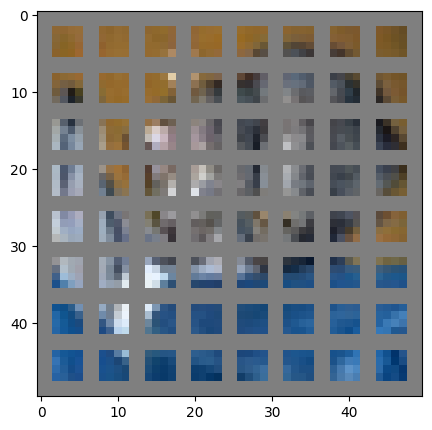

In [ ]:
# Visualize patches of the first image
patches = extract_patches(test_images, patch_size=patch_size)
patches_square = patches.reshape(test_images.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self,
               d_model: int,
               seq_length: int):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    seq_length: length of a sequence
    """
    super().__init__()

    pe = torch.zeros(seq_length, d_model) # (seq_length, d_model)

    # Create position column
    k = torch.arange(0, seq_length).unsqueeze(dim=1)

    # Use the log version of the function for positional encodings
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    # Use sine for the even indices and cosine for the odd indices
    pe[:, 0::2] = torch.sin(k * div_term)
    pe[:, 1::2] = torch.cos(k * div_term)

    pe = pe.unsqueeze(dim=0) # Add the batch dimension

    # We use a buffer because the positional encoding is fixed and not a model paramter that we want to be updated during backpropagation.
    self.register_buffer("pe", pe) # Buffers are saved with the model state and are moved to the correct device

  def forward(self, x):
    # x shape: (batch_size, seq_length, d_model)
    # Add the positional encoding to the embeddings that are passed in
    return x + self.pe[:, :x.size(1)]

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 4,
               d_model: int = 768,
               img_size: int = 28):
    super().__init__()

    self.patch_size = patch_size
    self.d_model = d_model
    self.projection = nn.Linear(in_channels * patch_size * patch_size, d_model)

    # Class token with a size of (1, 1, d_model)
    self.cls_token = nn.Parameter(torch.rand(1, 1, d_model))

    # Calculate the total sequence length (patches + 1 for the class token)
    num_patches = (img_size // patch_size) ** 2
    seq_length = num_patches + 1

    self.pos_embed = PositionalEncoding(d_model=d_model, seq_length=seq_length)

  def forward(self, x):
    # x shape: (batch_size, in_channels, h, w)
    batch_size, c, h, w = x.size()

    # Unfold to extract patches: shape becomes (batch_size, in_channels * patch_size * patch_size, num_patches)
    # num_patches = (H / patch_size) * (W / patch_size)
    unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
    patches = unfold(image_tensor)

    # Transpose to (batch_size, num_patches, in_channels * patch_size * patch_size)
    patches = patches.transpose(1, 2)

    # Apply linear projection to each patch: (batch_size, num_patches, in_channels * patch_size * patch_size) -> (batch_size, num_patches, d_model)
    patch_embeddings = self.proj(patches)

    # Expand class token for the batch: (batch_size, 1, d_model)
    cls_tokens = self.cls_token.expand(B, -1, -1)

    # Concatenate the class token with the patch embeddings: (B, num_patches + 1, d_model)
    embeddings = torch.cat([cls_tokens, patch_embeddings], dim=1)

    # Add positional encoding to the tokens
    embeddings = self.pos_embed(embeddings)
    return embeddings

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    assert d_model % n_heads == 0 # We want to make sure that the dimensions are split evenly among the attention heads.
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_key = d_model // n_heads

    self.Wq = nn.Linear(d_model, d_model)
    self.Wk = nn.Linear(d_model, d_model)
    self.Wv = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(p=0.1)

    self.attention_probs = None

  def forward(self, x):
    """
    x: (batch_size, length, d_model)
    """
    batch_size, n, d_input = x.shape

    # Matrix multiplication for Q, K, and V tensors
    Q = self.Wq(x)
    K = self.Wk(x)
    V = self.Wv(x)

    # Split each tensor into heads
    Q = Q.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, q_length, d_key)
    K = K.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, k_length, d_key)
    V = V.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, v_length, d_key)

    # Scaled dot product
    scaled_dot_product = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_key) # K^T becomees (batch_size, n_heads, d_key, k_length)

    # Softmax function for attention probabilities
    attention_probs = torch.softmax(scaled_dot_product, dim=-1)
    self.attention_probs = attention_probs

    # Multiply by V to get attention with respect to the values
    output = torch.matmul(self.dropout(attention_probs), V)

    # Reshape attention back to (batch_size, q_length, d_model)
    output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)

    return output

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model: int):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    self.ffn = nn.Sequential(
        nn.Linear(in_features=d_model, out_features=(d_model * 4)),
        nn.ReLU(),
        nn.Linear(in_features=(d_model * 4), out_features=d_model),
        nn.Dropout(p=0.1)
    )

  def forward(self, x):
    return self.ffn(x)

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()

    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(0.1)
    self.ffn = PositionwiseFeedForward(d_model=d_model)
    self.layer_norm_2 = nn.LayerNorm(d_model)

  def forward(self, x):
    # Multi-Head Self-Attention
    x = x + self.dropout(self.attention(self.layer_norm_1(x))) # Residual Addition and Layer Normalization
    # Feed-forward Network
    x = x + self.dropout(self.ffn(self.layer_norm_2(x))) # Residual Addition and Layer Normalization

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               n_layers,
               img_size,
               d_model,
               patch_size,
               n_heads,
               num_classes):
    super().__init__()

    self.patch_emb = PatchEmbedding(patch_size=patch_size, img_size=img_size, d_model=d_model)
    self.layers = nn.ModuleList([EncoderBlock(d_model=d_model, n_heads=n_heads) for layer in range(n_layers)])
    self.ff_out = nn.Linear(d_model, num_classes)

  def forward(self, x):
    # x: (batch_size, channels, height, width)
    x = self.patch_emb(x) # (batch_size, num_patches + 1, emb_dim) The + 1 comes from the class token

    for layer in self.layers:
      x = layer(x)

    return self.ff_out(x[:, 0, :]) # Get the class token from each batch with a size of d_model for the final class prediction

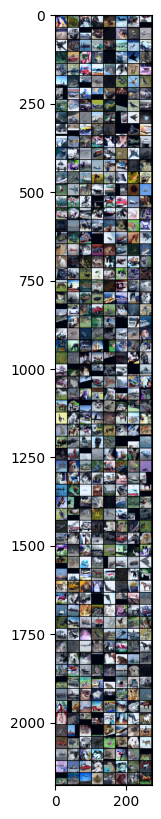

In [ ]:
# Create a dataloader itterable object
(train_images, train_labels) = next(iter(train_loader))

plt.figure(figsize=(20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
model = VisionTransformer(n_layers=12,
                          img_size=img_size_cifar,
                          d_model=768,
                          patch_size=4,
                          n_heads=12,
                          num_classes=len(class_names)).to(device)

In [ ]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print(f"This Model Has {num_model_params} Parameters")

This Model Has 78013450 Parameters


In [ ]:
out = model(test_images.to(device))
out.shape

torch.Size([512, 10])

In [ ]:
optimizer = optim.AdamW(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=epochs,
                                                    eta_min=0)

In [ ]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fn):
  model.train()

  for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
    x, y = x.to(device), y.to(device)
    output = model(x)

    # Calculate loss using loss function
    loss = loss_fn(output, y)

    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

  return model, optimizer, loss.item()

In [ ]:
def evaluate(model, device, loader):
  epoch_acc = 0
  model.eval()

  with torch.inference_mode():
      for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
        x, y = x.to(device), y.to(device)
        output = model(x.to(device))

        # Log the cumulative sum of the acc
        epoch_acc += (output.argmax(1) == y.to(device)).sum().item()

  # Return the accuracy from the epoch
  return epoch_acc / len(loader.dataset)

In [ ]:
valid_acc = 0
train_acc = 0

model_path = "vision_transformer_model.pt"

if os.path.exists(model_path):
  print(f"Loading model from {model_path}...")
  model.load_state_dict(torch.load(model_path, map_location=device))
else:
  print("No saved model found. Starting training...")

  pbar = trange(0, epochs, leave=False, desc="Epoch")
  for epoch in pbar:
    pbar.set_postfix_str(f"Train loss: {train_loss}")

    model, optimizer, train_loss = train(model=model,optimizer=optimizer,
                                         loader=train_loader,
                                         device=device,
                                         loss_fn=loss_fn)

    message = f"Epoch: {epoch + 1} | Train Loss: {train_loss} --> STORED"

    torch.save(model.state_dict(), model_path)

    print(message)

    # Reduce learning rate
    lr_scheduler.step()

No saved model found. Starting training...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.9886994361877441 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 1.6701754331588745 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 1.4227862358093262 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 1.2826093435287476 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.360454797744751 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 1.245152235031128 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 1.2347975969314575 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 1.126051902770996 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 1.1650608777999878 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 1.0318348407745361 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 1.0037882328033447 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.9109664559364319 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.8873106241226196 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.7642102241516113 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.8225324749946594 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.8777350187301636 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.645413875579834 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.619166374206543 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.6463205218315125 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.6686041355133057 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.6767672300338745 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.6003610491752625 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.5123557448387146 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 0.504235565662384 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.49958890676498413 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 26 | Train Loss: 0.47348740696907043 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 0.5264185667037964 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 0.4231095612049103 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 0.40662676095962524 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 0.44493594765663147 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 0.3950215280056 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 0.35710424184799194 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 0.38245639204978943 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 0.3527968227863312 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 0.3364183306694031 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 0.31806597113609314 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 0.3445553481578827 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 0.3146030008792877 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 0.320455938577652 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 0.32219043374061584 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 41 | Train Loss: 0.3124586343765259 --> STORED


Training:   0%|          | 0/88 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

The total test accuracy is: 77.38%


Predicted Values
 ['ship', 'ship', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog']
True Values
 ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


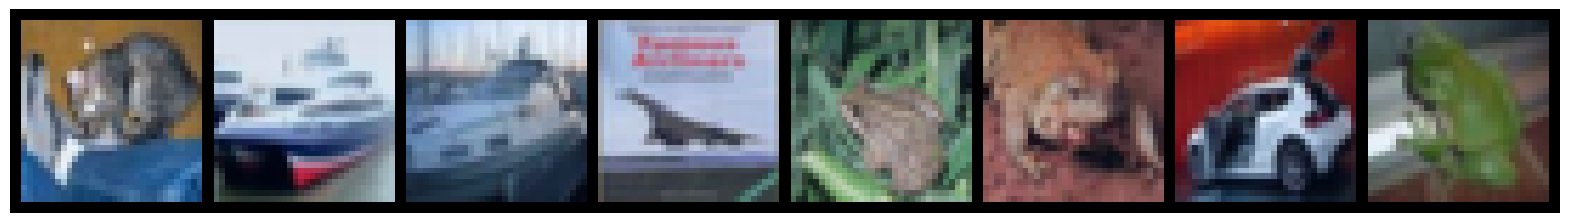

In [ ]:
with torch.inference_mode():
  fx = model(test_images[:8].to(device))
  pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
plt.axis(False)
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", [class_names[x] for x in list(pred.cpu().numpy())])
print("True Values\n", [class_names[x] for x in list(test_labels[:8].numpy())])

In [ ]:
import cv2

def visualize_attention(model, image, patch_size=4):
  model.eval()

  image = image.unsqueeze(0).to(device)
  output = model(image)

  # Retrieve attention maps from the last encoder block.
  last_attn = model.layers[-1].attention.attention_probs  # (batch_size, n_heads, tokens, tokens)

  # Get the class token of each batch at every head
  cls_attn = last_attn[:, :, 0, 1:] # Shape: (batch_size, n_heads, num_patches)

  cls_attn_avg = cls_attn.mean(dim=1) # Average over heads: resulting shape (batch_size, num_patches)

  # Determine grid size from the number of patches.
  num_patches = cls_attn_avg.shape[-1]
  grid_size = int(math.sqrt(num_patches))

  # Reshape the attention for the first image into a grid.
  attn_map = cls_attn_avg[0].reshape(grid_size, grid_size).cpu().detach().numpy()

  # Upsample the attention map to the original image size.
  attn_map_up = cv2.resize(attn_map, (image.shape[-1], image.shape[-2]))

  # Convert the image back to CPU and unnormalize for display if needed.
  img_disp = image[0].detach().cpu().permute(1, 2 ,0).numpy() # (H, W, C)
  img_disp = np.clip(img_disp, 0, 1)

  plt.figure(figsize=(4, 4))
  plt.imshow(img_disp)
  plt.imshow(attn_map_up, cmap='jet', alpha=0.3)
  plt.colorbar(label="Attention")
  plt.title("Attention Map Overlay")
  plt.axis(False)
  plt.show()

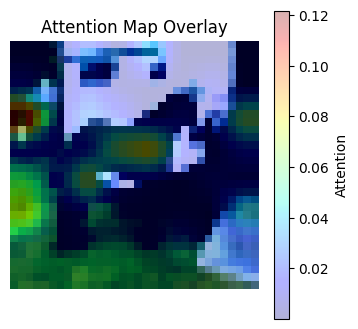

In [ ]:
test_img = test_images[20]
visualize_attention(model, test_img, patch_size=patch_size)